In [1]:
# import the transcriptome data
import os
import dandelion as ddl
import pandas as pd
import scanpy as sc
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 leidenalg==0.8.2


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
ddl.__version__

'0.0.26'

In [4]:
os.getcwd()

'/lustre/scratch117/cellgen/team297/kt16/newcastle_covid/notebooks'

In [5]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/newcastle_covid')

In [6]:
# already populated because i ran through the whole notebook without realizing the mistake in sanger bcr barcodes not matching up
bdata = sc.read_h5ad('h5ad/combined_dec_bcells.h5ad')
bprotein = sc.read_h5ad('h5ad/combined_dec_bcells_protein.h5ad')

In [7]:
# B cell gene set tests
# df1 = pd.read_csv('datasets/GSE22886_BcellGenesets.txt', sep = '\t', index_col = None, header = 0, na_filter=None)
# df2 = pd.read_csv('datasets/GSE38697_GSE12845_BcellGenesets.txt', sep = '\t', index_col = None, header = 0, na_filter=None)
# df3 = pd.read_csv('datasets/Bcell_genesets.txt', sep='\t', header=0, index_col = None, na_filter=False)
df4 = pd.read_csv('datasets/Monaco B cells.txt', sep='\t', header=0, index_col = None, na_filter=False)
# df5 = pd.read_csv('datasets/GSE17186_transitionalBcells.txt', sep='\t', header=0, index_col = None, na_filter=False)
# df6 = pd.read_csv('datasets/GSE12845_preGC_BcellGenesets.txt', sep='\t', header=0, index_col = None, na_filter=False)

In [8]:
if not os.path.exists('figures/heatmap'):
    os.makedirs('figures/heatmap')

In [9]:
def geneset_score(self, genesets, groupby, figsize=(3, 4), cmap = 'viridis', col_cluster = True, row_cluster = True, save = None):
    import numpy as np
    import seaborn as sns
    for s in genesets:
        sc.tl.score_genes(self, [y for y in genesets[s] if y != ''], use_raw = True, score_name= str(s)+'_score')
    # calculate average enrichment score
    list1 = list(set(self.obs[groupby]))
    subset = self.obs[[groupby] + [str(s)+'_score' for s in genesets]]
    output = pd.DataFrame()
    for x in list1:
        subsetX = subset[subset[groupby] == x]
        outdict = {}
        for k in [str(s)+'_score' for s in genesets]:
            out = {k:np.mean(subsetX[k])}
            outdict.update(out)
        output = output.append(outdict, ignore_index=True)
    output.index = list1
    output = output[[str(s)+'_score' for s in genesets]]
    g = sns.clustermap(output.transpose(), standard_scale = 0, cmap=cmap, figsize=figsize, col_cluster = col_cluster, row_cluster = row_cluster)
    sc.pl.umap(self, color = [str(s)+'_score' for s in genesets], size = 10, ncols = 2)
    if save is not None:
        g.savefig(save)
    else:
        print(g)

In [10]:
tmp = bdata.copy()

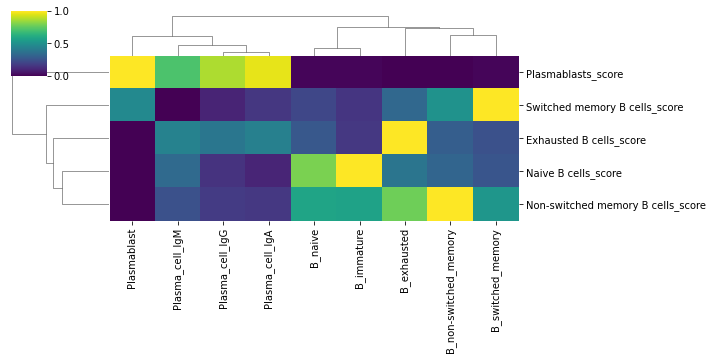

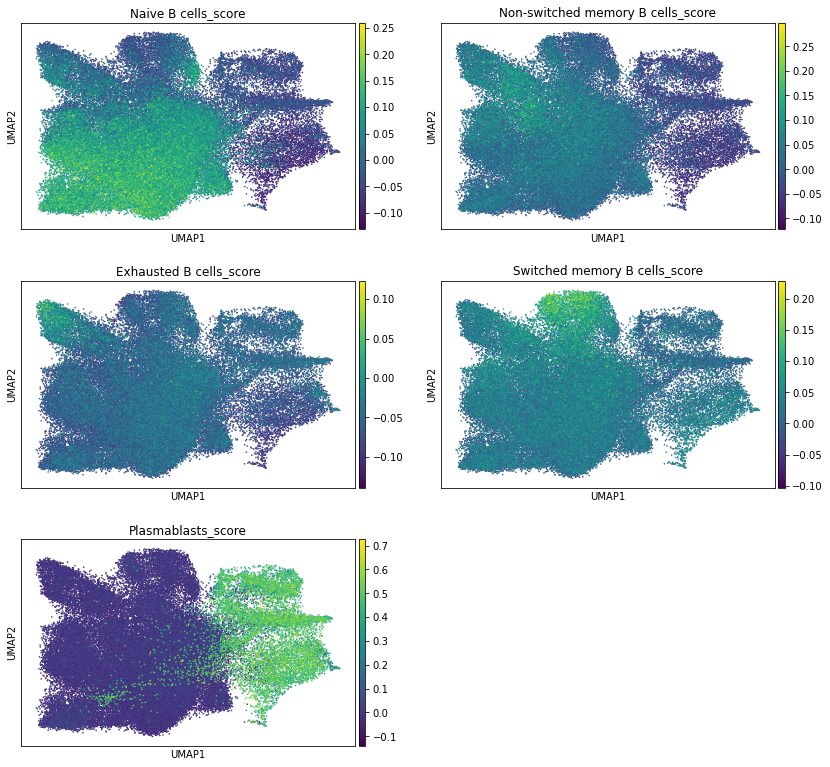

In [11]:
geneset_score(tmp, df4, 'celltype_B', (10,5), save = 'figures/heatmap/monaco_genesettest.pdf')

In [12]:
# check the HCA BM cell types
hcabm = sc.read_h5ad('/nfs/team297/kt16/scDatasets/Ben/HCA_bonemarrow_bcells.h5ad')
hcabm.raw = hcabm
sc.tl.rank_genes_groups(hcabm, groupby = 'celltype')
# we extract the DEGs as genesets
def returnDEres(adata, key, column, remove_mito_ribo = True):
    scores = pd.DataFrame(data = adata.uns[key]['scores'][column], index = adata.uns[key]['names'][column])
    lfc = pd.DataFrame(data = adata.uns[key]['logfoldchanges'][column], index = adata.uns[key]['names'][column])
    pvals = pd.DataFrame(data = adata.uns[key]['pvals'][column], index = adata.uns[key]['names'][column])
    padj = pd.DataFrame(data = adata.uns[key]['pvals_adj'][column], index = adata.uns[key]['names'][column])
    try:
        pts = pd.DataFrame(data = adata.uns[key]['pts'][column], index = adata.uns[key]['names'][column])
    except:
        pass
    scores = scores.loc[scores.index.dropna()]
    lfc = lfc.loc[lfc.index.dropna()]
    pvals = pvals.loc[pvals.index.dropna()]
    padj = padj.loc[padj.index.dropna()]
    try:
        pts = pts.loc[pts.index.dropna()]
    except:
        pass
    try:
        dfs = [scores, lfc, pvals, padj, pts]
    except:
        dfs = [scores, lfc, pvals, padj]
    df_final = functools.reduce(lambda left,right: pd.merge(left,right,left_index = True, right_index = True), dfs)
    try:
        df_final.columns = ['scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'pts']
    except:
        df_final.columns = ['scores', 'logfoldchanges', 'pvals', 'pvals_adj']
    if remove_mito_ribo:
        df_final = df_final[~df_final.index.isin(list(df_final.filter(regex='^RPL|^RPS|^MRPS|^MRPL|^MT-', axis = 0).index))]	
    return(df_final)
import functools
hsc = returnDEres(hcabm, 'rank_genes_groups', 'HSC')
bcell = returnDEres(hcabm, 'rank_genes_groups', 'B cell')
immbcell = returnDEres(hcabm, 'rank_genes_groups', 'Immature B cell')
probcell = returnDEres(hcabm, 'rank_genes_groups', 'pro B cell')
preprobcell = returnDEres(hcabm, 'rank_genes_groups', 'pre pro B cell')
prebcell = returnDEres(hcabm, 'rank_genes_groups', 'pre B cell')
hsc = list(hsc[(hsc['pvals_adj'] < 0.05) & (hsc['logfoldchanges'] > .58)].head(n=250).index)
bcell = list(bcell[(bcell['pvals_adj'] < 0.05) & (bcell['logfoldchanges'] > .58)].head(n=250).index)
immbcell = list(immbcell[(immbcell['pvals_adj'] < 0.05) & (immbcell['logfoldchanges'] > .58)].head(n=250).index)
probcell = list(probcell[(probcell['pvals_adj'] < 0.05) & (probcell['logfoldchanges'] > .58)].head(n=250).index)
preprobcell = list(preprobcell[(preprobcell['pvals_adj'] < 0.05) & (preprobcell['logfoldchanges'] > .58)].head(n=250).index)
prebcell = list(prebcell[(prebcell['pvals_adj'] < 0.05) & (prebcell['logfoldchanges'] > .58)].head(n=250).index)
df7 = pd.DataFrame([hsc, bcell, immbcell, probcell, preprobcell, prebcell]).T
df7.columns = ['HSC', 'B cell', 'Immature B cell', 'pro B cell', 'pre pro B cell', 'pre B cell']

/nfs/users/nfs_k/kt16/miniconda2/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


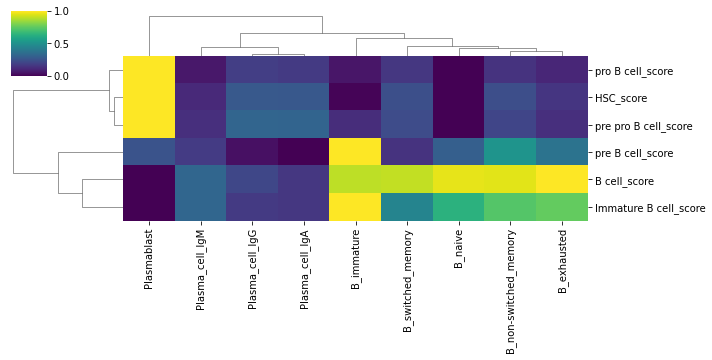

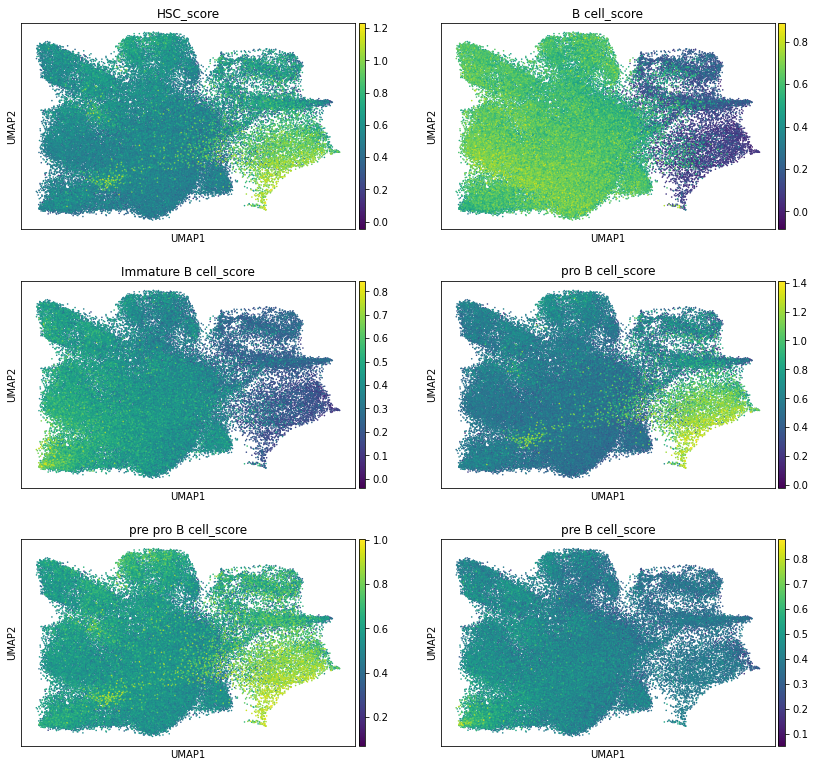

In [13]:
geneset_score(tmp, df7, 'celltype_B', (10,5), save = 'figures/heatmap/HCA_bonemarrow_genesettest.pdf')

In [14]:
if not os.path.exists('figures/umap'):
    os.makedirs('figures/umap')

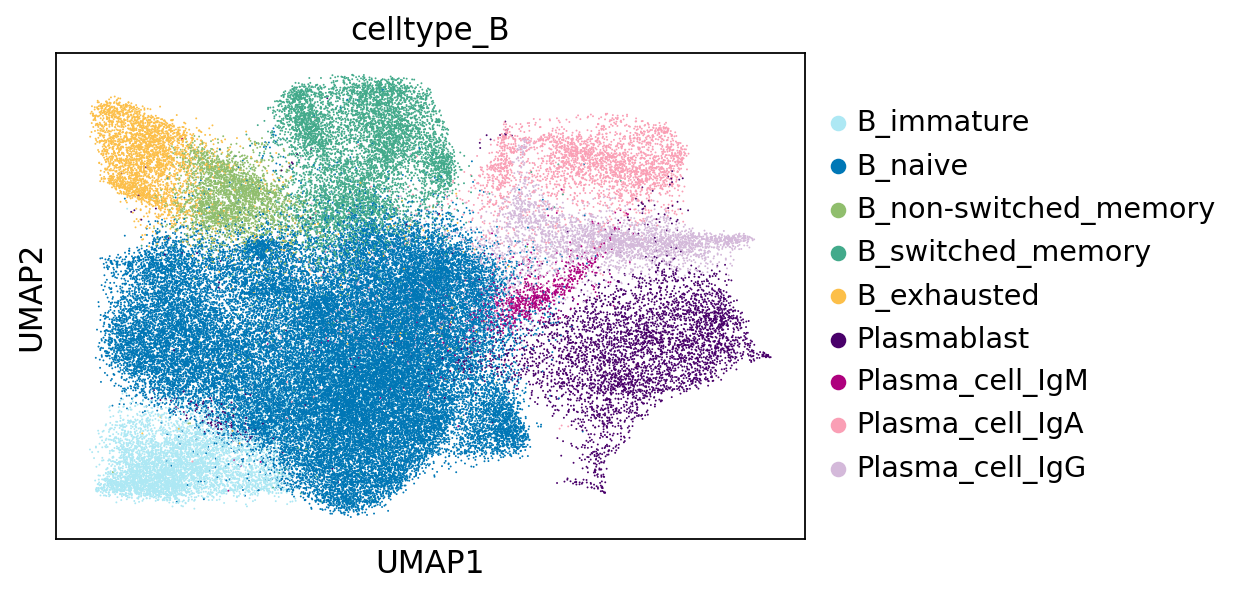

In [15]:
sc.set_figure_params(figsize=(6,4), dpi_save = 900)
sc.pl.umap(bdata, color = 'celltype_B', size = 3, save = '/Bcell_umap.pdf')

In [16]:
bdata.uns['celltype_B_colors']

array(['#ade8f4', '#0077b6', '#90be6d', '#43aa8b', '#fcbf49', '#49006a',
       '#ae017e', '#fa9fb5', '#d4b9da'], dtype=object)

In [17]:
if not os.path.exists('figures/dotplot'):
    os.makedirs('figures/dotplot')

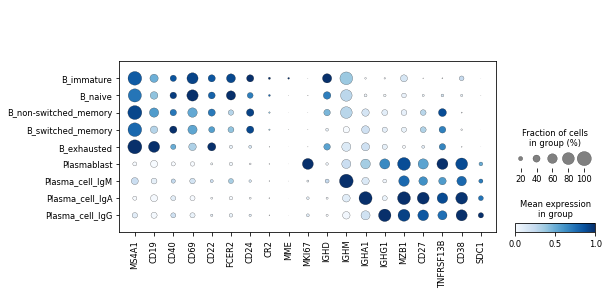

In [17]:
ax = sc.pl.dotplot(bdata, 
                   ['MS4A1', 'CD19', 'CD40', 'CD69', 'CD22', 'FCER2', 'CD24', 'CR2', 'MME', 'MKI67', 'IGHD', 'IGHM', 'IGHA1', 'IGHG1', 'MZB1', 'CD27', 'TNFRSF13B', 'CD38', 'SDC1'],
                   groupby = 'celltype_B',  
                   standard_scale = 'var', color_map = 'Blues', return_fig=True)
# ax.style(dot_edge_lw=0, cmap = 'Blues')
ax.savefig('figures/dotplot/Bcell_trans_markers.pdf')

/nfs/users/nfs_k/kt16/miniconda2/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


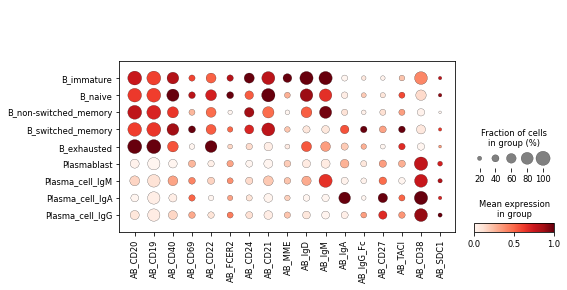

In [18]:
ax = sc.pl.dotplot(bprotein, 
                     ['AB_CD20', 'AB_CD19', 'AB_CD40', 'AB_CD69', 'AB_CD22', 'AB_FCER2', 'AB_CD24', 'AB_CD21', 'AB_MME', 'AB_IgD', 'AB_IgM', 'AB_IgA', 'AB_IgG_Fc', 'AB_CD27', 'AB_TACI', 'AB_CD38', 'AB_SDC1'],
                     groupby = 'celltype_B',  
                     standard_scale = 'var', color_map = 'Reds', return_fig=True)
# ax.style(dot_edge_lw=0, cmap = 'Reds')
ax.savefig('figures/dotplot/Bcell_cite_markers.pdf')

In [20]:
# save out for plotting barcharts in R
bdata.obs.to_csv('h5ad/combined_dec_bcells_obs.csv')

In [21]:
bdata

AnnData object with n_obs × n_vars = 74019 × 1064
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'initial_clustering', 'Resample', 'Collection_Day', 'patient_id', 'Sex', 'Age', 'Ethnicity', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Status_3_days_post_collection', 'Status_7_days_post_collection', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'initial_clustering_B', 'leiden_B', 'leiden_B2', 'celltype_B', 'celltype_B_v2'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Site_colors', 'Status_on_day_collection_summary_colors', 'bcr_QC_pass_colors', 'celltype_B_colors', 'celltype_B_v2_colors', "dendrogram_['leiden_B']", "dendrogram_['leiden_B2']", 'filter_

In [7]:
vdj = ddl.read_h5('dandelion_output/combined_dec_vdj_bcells.h5')
vdj

Dandelion class object with n_obs = 43841 and n_contigs = 89171
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_star

In [8]:
# do a simple transfer
ddl.tl.transfer(bdata, vdj)

In [9]:
ddl.tl.clone_overlap(bdata, groupby = 'patient_id', colorby = 'Status_on_day_collection_summary')

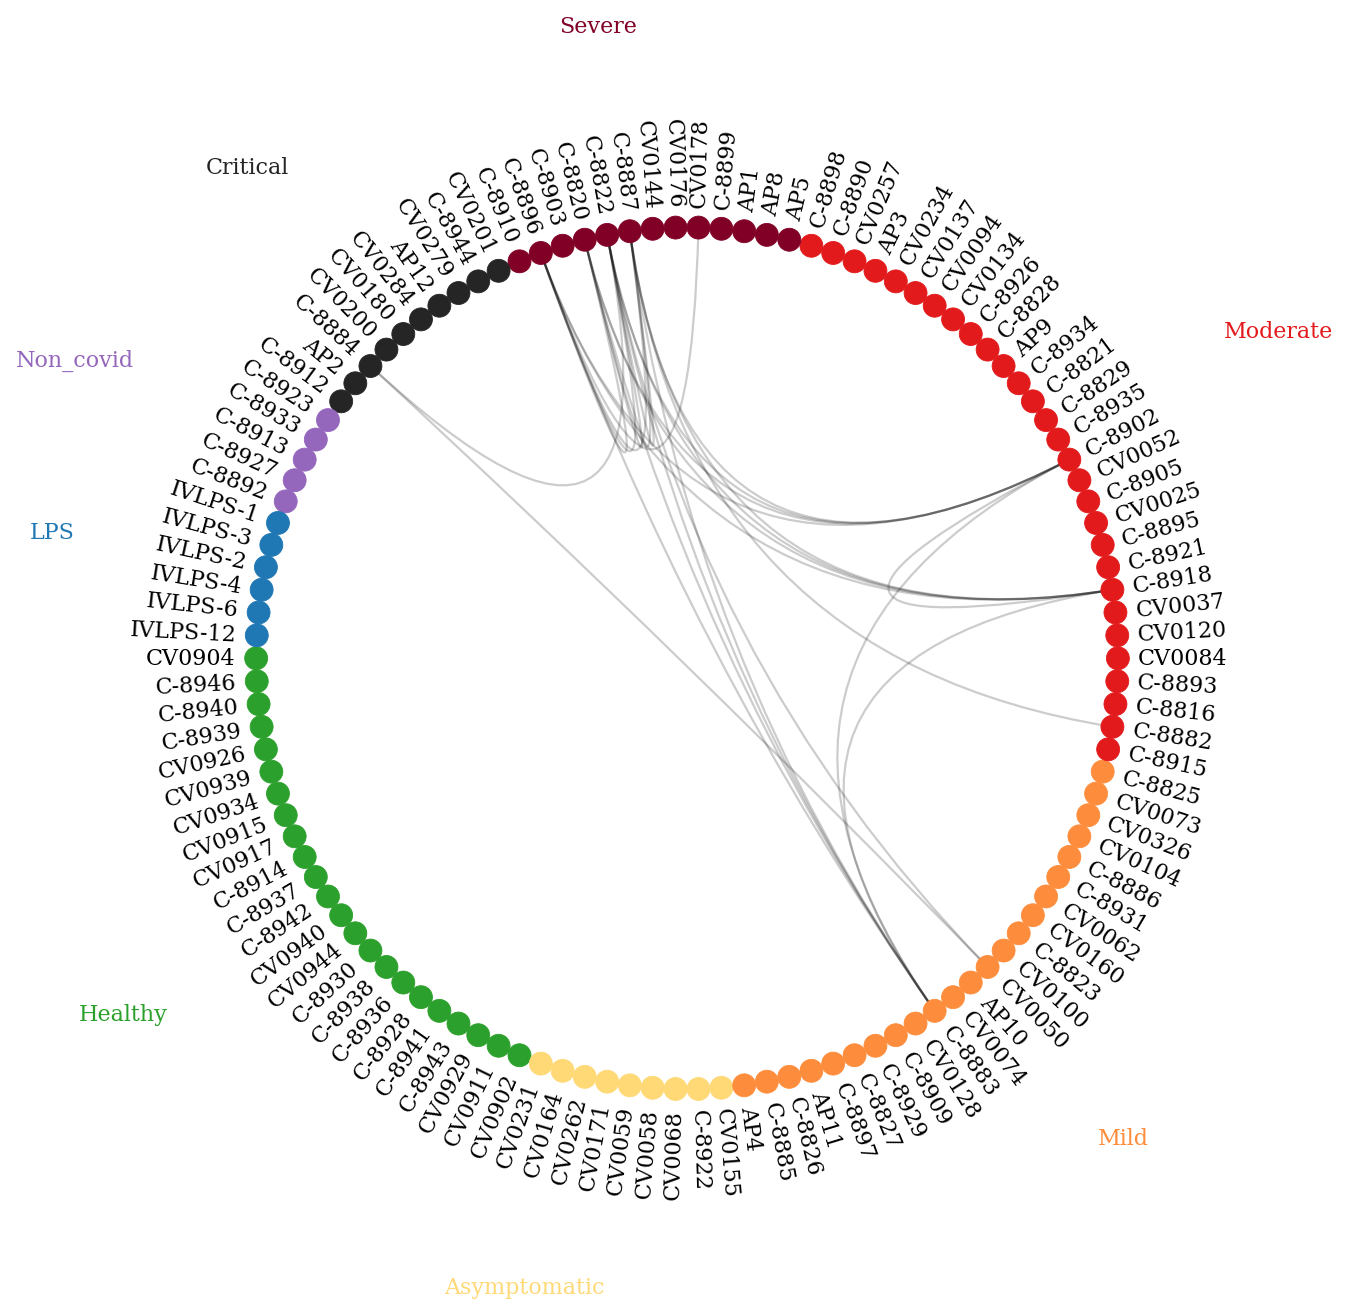

In [26]:
if not os.path.exists('figures/clone_overlap'):
    os.makedirs('figures/clone_overlap')
ddl.pl.clone_overlap(bdata, groupby = 'patient_id', colorby = 'Status_on_day_collection_summary', group_label_offset=15, save = 'figures/clone_overlap/covid_clone_overlap.pdf')

In [30]:
bdata = bdata[bdata.obs['bcr_QC_pass'] == 'True']
bdata

/nfs/users/nfs_k/kt16/miniconda2/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 47410 × 1064
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'initial_clustering', 'Resample', 'Collection_Day', 'patient_id', 'Sex', 'Age', 'Ethnicity', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Status_3_days_post_collection', 'Status_7_days_post_collection', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'initial_clustering_B', 'leiden_B', 'leiden_B2', 'celltype_B', 'celltype_B_v2', 'clone_id', 'clone_id_by_size', 'isotype', 'lightchain', 'status', 'vdj_status', 'productive', 'umi_counts_heavy', 'umi_counts_light', 'v_call_heavy', 'v_call_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light'
    var: 'feature_types', 'highly_variable', 'means', 'disper

In [33]:
# save out for plotting barcharts in R
bdata.obs.to_csv('h5ad/combined_dec_bcells_obs_vdj.csv')

In [8]:
genes = {
    'TNF signaling':["FOS", "KLF2", "PNRC1", "NFKB1", "JUN", "DUSP1", "FOSB", "GADD45B", "IER2", "ZFP36", "PPP1R15A", "NFKBIA", "CD69", "BTG2"],
    'BCR signaling - activating':['CD79A', 'CD79B', 'CD19', 'CD40', 'PTPRC', 'LYN', 'BLNK', 'BTK', 'BLK'],
    'BCR signaling - inhibitory':['FCGR2B', 'CD22', 'CD72', 'SIGLEC10', 'PECAM1', 'PTPN6', 'PTPN11', 'INPP5D']}


In [12]:
from collections import defaultdict
adata = defaultdict(dict)
bdata = bdata[~(bdata.obs['Status_on_day_collection_summary'].isin(['LPS', 'Non_covid']))]
for x in list(set(bdata.obs['celltype_B_v2'])):
    adata[x] = bdata[bdata.obs['celltype_B_v2'] == x].copy()

/nfs/users/nfs_k/kt16/miniconda2/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


B_switched_memory
Plasmablast
B_naive
B_exhausted
B_immature
Plasma_cell
B_non-switched_memory


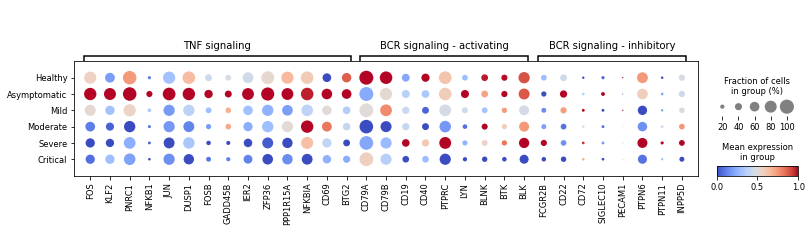

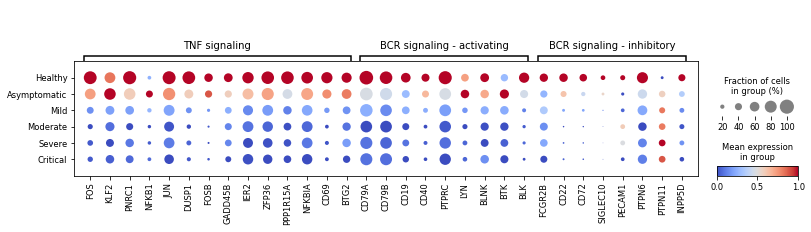

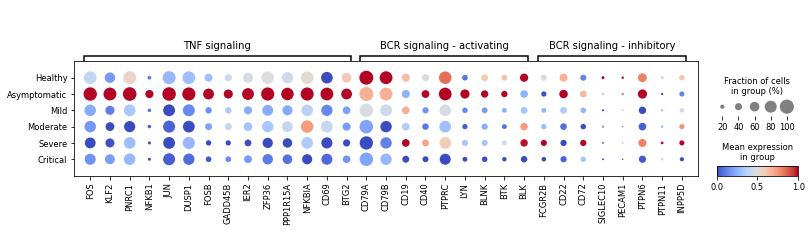

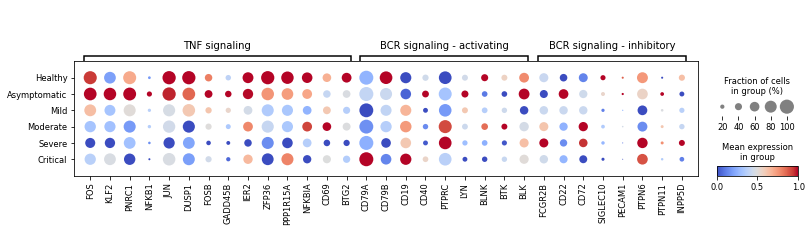

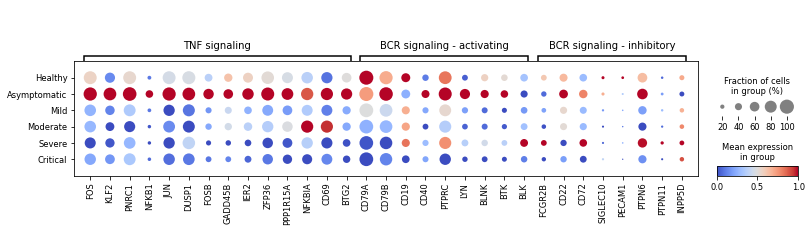

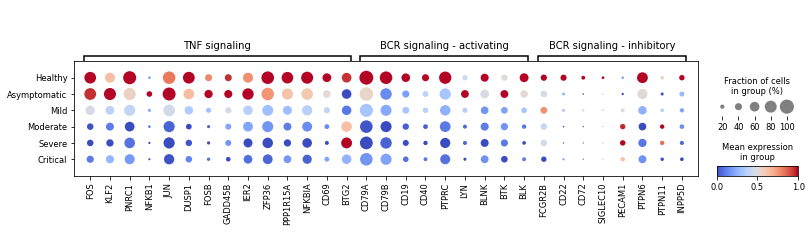

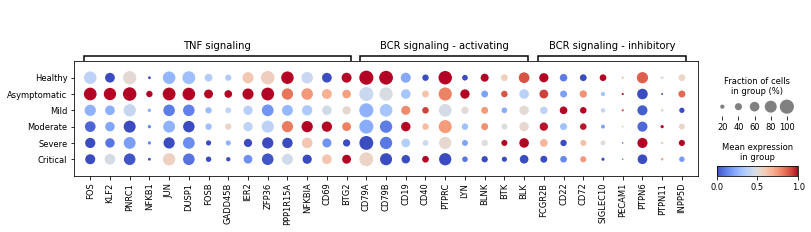

In [17]:
for x in adata:
    print(x)
    ax = sc.pl.dotplot(adata[x], genes, groupby = 'Status_on_day_collection_summary', standard_scale = 'var', return_fig=True, var_group_rotation =0)
    ax.style(dot_edge_lw=0, cmap = 'coolwarm')
#     ax.show()
    ax.savefig('figures/dotplot/'+x+'_dotplots.pdf')